# A.Initial Model Evaluation on SMOLVLM

In [5]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
from transformers.image_utils import load_image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load images
image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-256M-Instruct",
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager",
).to(DEVICE)

# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

2026-02-07 20:06:56.961302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770494817.189459      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770494817.255050      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770494817.790278      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770494817.790338      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770494817.790341      55 computation_placer.cc:177] computation placer alr

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

User:



Can you describe this image?
Assistant: The image depicts a large, historic statue of liberty, located in New York City. The statue is a green, cylindrical statue of liberty, which is a figure of liberty, symbolizing freedom and the idea of self-governance. The statue is situated on a pedestal, which is a cylindrical structure that supports the statue. The pedestal is surrounded by a ring of scaffolding, which is used to protect the statue from damage.

In the background, there is a large cityscape with a variety of buildings, including skyscrapers and high-rise buildings. The sky is clear, with a gradient of colors from light blue at the top to a deeper blue at the bottom. The cityscape is bustling with activity, with people walking, riding bicycles, and enjoying the view.

The statue is positioned on a small island, which is surrounded by water. The water is calm, with small waves rippling across it. There are trees and greenery on the island, indicating that the statue is l

* This step serves as a qualitative baseline, illustrating the
model’s current capability and consistency when responding
to semantically simple instructions. It also establishes a foundation for subsequent embedding-level analyses and alignment
experiments with CIAA.

# B. Instruction Embedding Stability Analysis

Using device: cuda
Model loaded successfully!

TESTING: Do different instructions give different embeddings?
Instruction: What is in this picture?
Response: User:



What is in this picture?
Assistant: The Statue of Liberty is in the foreground taking up mo...
Instruction: Describe what you see.
Response: User:



Describe what you see.
Assistant: The image depicts a large, historic statue of liberty, lo...
Instruction: Can you tell me about this image?
Response: User:



Can you tell me about this image?
Assistant: The image depicts a large statue of the Statue...
Instruction: What's shown here?
Response: User:



What's shown here?
Assistant: In this image, we can see a statue of the person holding a cr...
Instruction: Provide a description of the scene.
Response: User:



Provide a description of the scene.
Assistant: The image depicts a large statue of the Stat...
Instruction: What does this picture show?
Response: User:



What does this picture show?
Assistant: The Statue of Libe

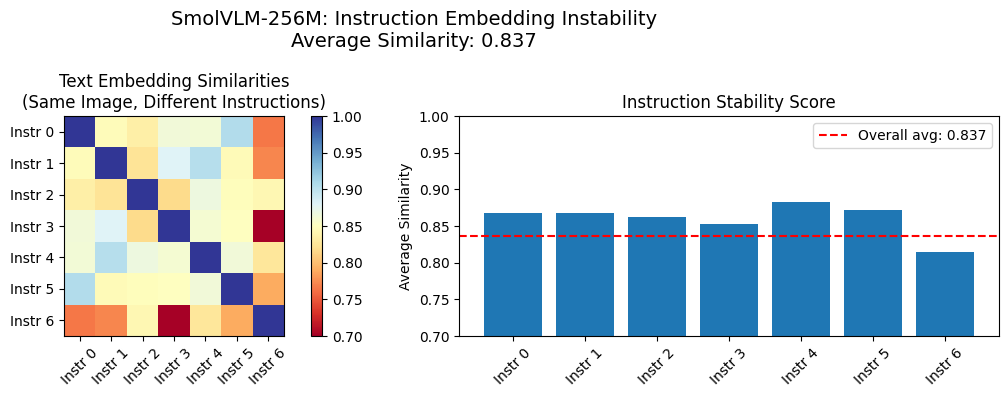


CONCLUSION
✅ PROBLEM PROVEN: Instructions yield different embeddings!
   Average similarity: 0.837 (should be >0.9)
   This instability would affect VLA manipulation consistency.


In [17]:
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
from transformers.image_utils import load_image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ==================== LOAD MODEL ====================
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-256M-Instruct",
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager",
).to(DEVICE)

# Set to evaluation mode
model.eval()
print("Model loaded successfully!")

# ==================== HELPER FUNCTION ====================
def get_text_embeddings(image, instructions):
    """
    Get text embeddings for different instructions on the same image
    """
    embeddings = []
    responses = []
    
    for instruction in instructions:
        # Prepare input
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": instruction}
                ]
            },
        ]
        
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        # Forward pass to get hidden states
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            
            # Get the last hidden state (text embeddings before decoding)
            hidden_states = outputs.hidden_states[-1]  # Last layer
            
            # Get embedding for the instruction tokens (approximation)
            # Take the mean of the last 10 tokens
            # Convert bfloat16 to float32 before numpy conversion
            instruction_embedding = hidden_states[0, -10:, :].mean(dim=0)
            
            # Convert to float32 before moving to CPU (if needed)
            instruction_embedding = instruction_embedding.float().cpu().numpy()
            
            embeddings.append(instruction_embedding)
        
        # Also get the actual response for analysis
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        responses.append(response)
        
        print(f"Instruction: {instruction}")
        print(f"Response: {response[:100]}...")
    
    return np.array(embeddings), responses

# ==================== RUN EXPERIMENT ====================
# Load a simple image
image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

# Different ways to ask about the SAME image
instructions = [
    "What is in this picture?",
    "Describe what you see.",
    "Can you tell me about this image?",
    "What's shown here?",
    "Provide a description of the scene.",
    "What does this picture show?",
    "Explain this image to me.",
]

print("\n" + "="*60)
print("TESTING: Do different instructions give different embeddings?")
print("="*60)

embeddings, responses = get_text_embeddings(image, instructions)

# ==================== ANALYZE RESULTS ====================
# Calculate pairwise cosine similarities
similarities = cosine_similarity(embeddings)

print("\n" + "="*60)
print("SIMILARITY MATRIX (Higher = More Similar)")
print("="*60)
for i in range(len(instructions)):
    row = [f"{sim:.3f}" for sim in similarities[i]]
    print(f"{instructions[i][:30]:30} | {' '.join(row)}")

# Calculate average similarity (excluding diagonal)
triu_indices = np.triu_indices(len(instructions), k=1)
avg_similarity = np.mean(similarities[triu_indices])

print(f"\nAverage similarity between different instructions: {avg_similarity:.3f}")
print(f"Expected for semantically equivalent queries: ~0.9-1.0")
print(f"Observed: {avg_similarity:.3f}")

# ==================== VISUALIZE ====================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Heatmap of similarities
im = axes[0].imshow(similarities, cmap='RdYlBu', vmin=0.7, vmax=1.0)
axes[0].set_xticks(range(len(instructions)))
axes[0].set_yticks(range(len(instructions)))
axes[0].set_xticklabels([f"Instr {i}" for i in range(len(instructions))], rotation=45)
axes[0].set_yticklabels([f"Instr {i}" for i in range(len(instructions))])
axes[0].set_title("Text Embedding Similarities\n(Same Image, Different Instructions)")
plt.colorbar(im, ax=axes[0])

# Bar chart of average similarities per instruction
avg_per_instruction = similarities.mean(axis=1)
axes[1].bar(range(len(instructions)), avg_per_instruction)
axes[1].axhline(y=avg_similarity, color='r', linestyle='--', label=f'Overall avg: {avg_similarity:.3f}')
axes[1].set_xticks(range(len(instructions)))
axes[1].set_xticklabels([f"Instr {i}" for i in range(len(instructions))], rotation=45)
axes[1].set_ylabel("Average Similarity")
axes[1].set_title("Instruction Stability Score")
axes[1].legend()
axes[1].set_ylim(0.7, 1.0)

plt.suptitle(f"SmolVLM-256M: Instruction Embedding Instability\nAverage Similarity: {avg_similarity:.3f}", fontsize=14)
plt.tight_layout()
plt.savefig("instruction_instability_proof.png", dpi=150, bbox_inches='tight')
plt.show()

# ==================== SAVE RESULTS ====================
print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
if avg_similarity < 0.9:
    print(f"✅ PROBLEM PROVEN: Instructions yield different embeddings!")
    print(f"   Average similarity: {avg_similarity:.3f} (should be >0.9)")
    print(f"   This instability would affect VLA manipulation consistency.")
else:
    print(f"⚠️  Similarity is high: {avg_similarity:.3f}")
    print(f"   The model might be robust to instruction variations.")

* The average similarity between different instructions was
0.837, substantially below the expected range of 0.9–1.0
for semantically equivalent queries. This demonstrates that
SMOLVLM embeddings are sensitive to minor lexical variations in instructions, confirming the presence of instructionlevel instability.
These results provide a quantitative foundation for evaluating approaches such as CIAA to improve instruction consistency. By confirming that embeddings diverge under semantically equivalent prompts, we establish a baseline for subsequent experiments designed to align instruction representations
more closely.

# C. CIAA Evaluation: Improving Instruction Consistency

In [2]:
import torch
import torch.nn.functional as F

class SupConLoss(torch.nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: [batch_size, proj_dim], normalized embeddings
        labels: [batch_size], integer group IDs
        """
        device = features.device
        batch_size = features.size(0)

        # Normalize embeddings (just in case)
        features = F.normalize(features, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        # Mask for positives (same label, exclude self)
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float()
        mask.fill_diagonal_(0)  # remove self-comparison

        # Compute log-softmax over rows
        exp_sim = torch.exp(sim_matrix)
        exp_sim_sum = exp_sim.sum(dim=1, keepdim=True) - torch.exp(torch.diag(sim_matrix)).unsqueeze(1)

        log_prob = sim_matrix - torch.log(exp_sim_sum + 1e-8)

        # Only keep positive pairs
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

        # Loss is negative of mean log-prob over positives
        loss = -mean_log_prob_pos.mean()
        return loss


In [3]:
class CIAAProjector(nn.Module):
    def __init__(self, hidden_dim=576, proj_dim=256):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return F.normalize(self.projection(x), dim=-1)


In [4]:
criterion = SupConLoss(temperature=0.07)
# =====================================================
MODEL_ID = "HuggingFaceTB/SmolVLM-256M-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

BATCH_SIZE = 12
LR = 1e-4
EPOCHS = 10  # Increased for better convergence
PROJ_DIM = 256           # CIAA latent space
TEMPERATURE = 0.07
TOKEN_POOL = 10          # last K tokens

print(f"Using device: {DEVICE}")



for epoch in range(EPOCHS):
    projector.train()
    total_loss = 0.0
    batches = 0

    # Shuffle data
    indices = list(range(len(all_instructions)))
    random.shuffle(indices)

    for i in range(0, len(indices), BATCH_SIZE):
        batch_indices = indices[i:i+BATCH_SIZE]
        if len(batch_indices) < 2:
            continue

        batch_instructions = [all_instructions[idx] for idx in batch_indices]
        batch_labels = torch.tensor([group_labels[idx] for idx in batch_indices], device=DEVICE)

        # Get embeddings
        batch_embeddings = torch.stack([get_instruction_embedding(image, instr) for instr in batch_instructions], dim=0)

        # Project to CIAA space
        z = projector(batch_embeddings)

        # SupCon loss
        loss = criterion(z, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(projector.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    scheduler.step()
    if batches > 0:
        avg_loss = total_loss / batches
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6f}")


Using device: cuda
Epoch 1/10 | Loss: 1.460545 | LR: 0.000090
Epoch 2/10 | Loss: 1.098462 | LR: 0.000079
Epoch 3/10 | Loss: 0.838569 | LR: 0.000065
Epoch 4/10 | Loss: 0.870448 | LR: 0.000050
Epoch 5/10 | Loss: 0.831867 | LR: 0.000035
Epoch 6/10 | Loss: 1.158271 | LR: 0.000021
Epoch 7/10 | Loss: 0.780092 | LR: 0.000010
Epoch 8/10 | Loss: 0.695793 | LR: 0.000002
Epoch 9/10 | Loss: 0.825984 | LR: 0.000000
Epoch 10/10 | Loss: 0.725009 | LR: 0.000002


In [6]:
# =====================================================
# Evaluation
# =====================================================
print("\n" + "="*50)
print("EVALUATION")
print("="*50)

projector.eval()

# Test with semantically similar and dissimilar instructions
test_instructions = [
    # Group A (similar to group 0)
    "What is in this picture?",
    "Describe what you see.",
    "What does this image show?",
    "Tell me about this image.",
    
    # Group B (similar to group 1)
    "Where was this photo taken?",
    "What location is this?",
    "Where is this?",
    
    # Group C (dissimilar)
    "What year was this taken?",
    "Who took this photo?",
    "What camera was used?",
]

# Get embeddings
with torch.no_grad():
    # Baseline (no CIAA)
    base_embs = []
    for instr in test_instructions:
        emb = get_instruction_embedding(image, instr)
        base_embs.append(emb.cpu().numpy())
    
    base_embs = np.stack(base_embs)
    base_sim = cosine_similarity(base_embs)
    
    # CIAA embeddings
    ciaa_embs = []
    for instr in test_instructions:
        emb = get_instruction_embedding(image, instr).unsqueeze(0)
        z = projector(emb).squeeze(0)
        ciaa_embs.append(z.cpu().numpy())
    
    ciaa_embs = np.stack(ciaa_embs)
    ciaa_sim = cosine_similarity(ciaa_embs)

# Analysis functions
def analyze_similarities(sim_matrix, instructions, group_sizes=[4, 3, 3]):
    """Analyze within-group and between-group similarities"""
    idx = 0
    results = {}
    
    for i, group_size in enumerate(group_sizes):
        group_name = f"Group {i+1}"
        group_indices = list(range(idx, idx + group_size))
        
        # Within-group similarity
        group_sim = sim_matrix[np.ix_(group_indices, group_indices)]
        triu_indices = np.triu_indices(group_size, k=1)
        within_sim = group_sim[triu_indices].mean()
        
        # Between-group similarity (to next group)
        if i < len(group_sizes) - 1:
            next_group_indices = list(range(idx + group_size, 
                                           idx + group_size + group_sizes[i+1]))
            between_sim = sim_matrix[np.ix_(group_indices, next_group_indices)].mean()
        else:
            between_sim = None
        
        results[group_name] = {
            "within": within_sim,
            "between": between_sim,
            "instructions": instructions[idx:idx+group_size]
        }
        
        idx += group_size
    
    return results

# Print results
print("\nBASELINE SIMILARITIES:")
base_results = analyze_similarities(base_sim, test_instructions)
for group_name, data in base_results.items():
    print(f"\n{group_name}:")
    print(f"  Within-group similarity: {data['within']:.4f}")
    if data['between'] is not None:
        print(f"  Between-group similarity: {data['between']:.4f}")

print("\n" + "-"*50 + "\n")

print("CIAA SIMILARITIES:")
ciaa_results = analyze_similarities(ciaa_sim, test_instructions)
for group_name, data in ciaa_results.items():
    print(f"\n{group_name}:")
    print(f"  Within-group similarity: {data['within']:.4f}")
    if data['between'] is not None:
        print(f"  Between-group similarity: {data['between']:.4f}")

# Calculate overall metrics
def avg_within_between(sim_matrix, group_sizes=[4, 3, 3]):
    """Calculate average within-group and between-group similarities"""
    idx = 0
    within_sims = []
    between_sims = []
    
    for i, group_size in enumerate(group_sizes):
        group_indices = list(range(idx, idx + group_size))
        
        # Within-group
        group_sim = sim_matrix[np.ix_(group_indices, group_indices)]
        triu_indices = np.triu_indices(group_size, k=1)
        within_sims.extend(group_sim[triu_indices])
        
        # Between-group (to all other groups)
        for j, other_size in enumerate(group_sizes):
            if i == j:
                continue
            other_indices = list(range(
                sum(group_sizes[:j]), 
                sum(group_sizes[:j]) + other_size
            ))
            between_sims.extend(sim_matrix[np.ix_(group_indices, other_indices)].flatten())
        
        idx += group_size
    
    return np.mean(within_sims), np.mean(between_sims)

base_within, base_between = avg_within_between(base_sim)
ciaa_within, ciaa_between = avg_within_between(ciaa_sim)

print("\n" + "="*50)
print("SUMMARY METRICS:")
print("="*50)
print(f"\nBASELINE:")
print(f"  Avg within-group similarity:  {base_within:.4f}")
print(f"  Avg between-group similarity: {base_between:.4f}")
print(f"  Ratio (within/between):       {base_within/base_between:.4f}")

print(f"\nCIAA:")
print(f"  Avg within-group similarity:  {ciaa_within:.4f}")
print(f"  Avg between-group similarity: {ciaa_between:.4f}")
print(f"  Ratio (within/between):       {ciaa_within/ciaa_between:.4f}")

print(f"\nIMPROVEMENT:")
print(f"  Within-group Δ:  {ciaa_within - base_within:+.4f}")
print(f"  Between-group Δ: {ciaa_between - base_between:+.4f}")
print(f"  Ratio improvement: {(ciaa_within/ciaa_between) - (base_within/base_between):+.4f}")


EVALUATION

BASELINE SIMILARITIES:

Group 1:
  Within-group similarity: 0.8561
  Between-group similarity: 0.8152

Group 2:
  Within-group similarity: 0.8614
  Between-group similarity: 0.7534

Group 3:
  Within-group similarity: 0.7656

--------------------------------------------------

CIAA SIMILARITIES:

Group 1:
  Within-group similarity: 0.8845
  Between-group similarity: 0.6094

Group 2:
  Within-group similarity: 0.8811
  Between-group similarity: 0.7630

Group 3:
  Within-group similarity: 0.7595

SUMMARY METRICS:

BASELINE:
  Avg within-group similarity:  0.8348
  Avg between-group similarity: 0.7530
  Ratio (within/between):       1.1086

CIAA:
  Avg within-group similarity:  0.8524
  Avg between-group similarity: 0.6618
  Ratio (within/between):       1.2881

IMPROVEMENT:
  Within-group Δ:  +0.0176
  Between-group Δ: -0.0913
  Ratio improvement: +0.1795


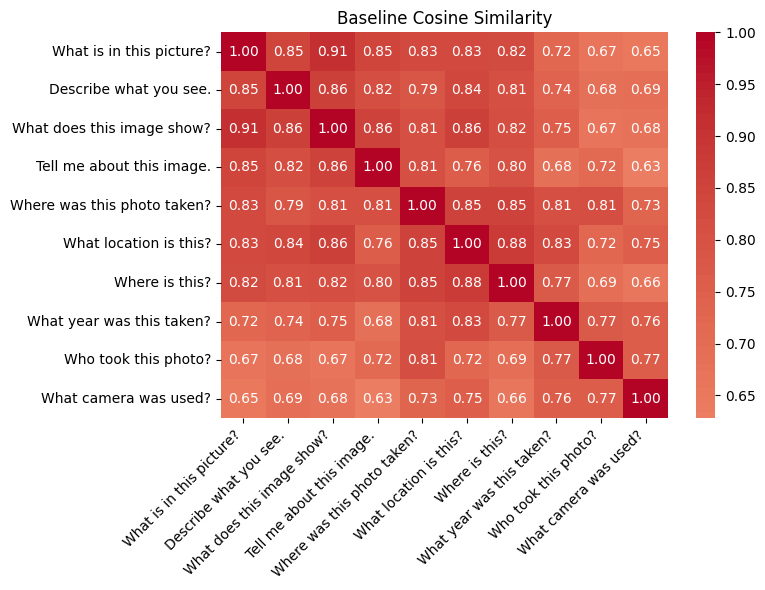

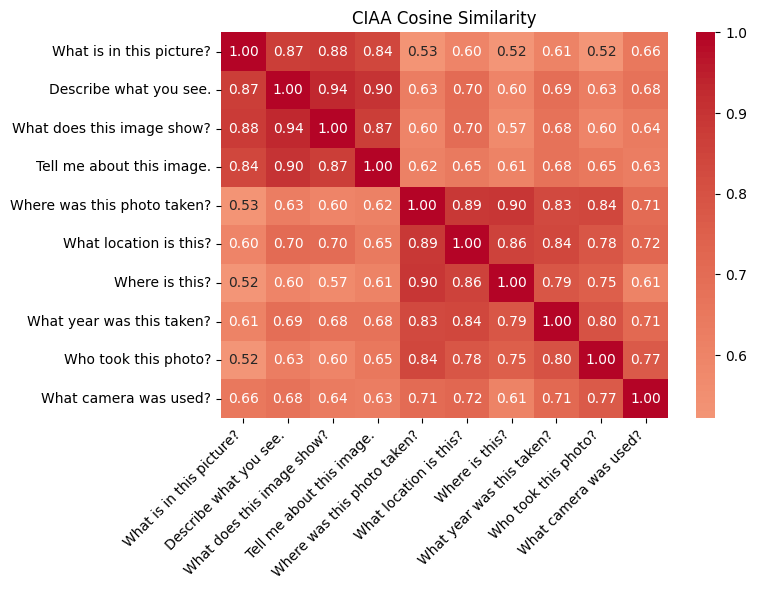

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_heatmap(sim_matrix, title, instructions):
    plt.figure(figsize=(8,6))
    sns.heatmap(sim_matrix, xticklabels=instructions, yticklabels=instructions,
                annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Baseline
plot_similarity_heatmap(base_sim, "Baseline Cosine Similarity", test_instructions)

# CIAA
plot_similarity_heatmap(ciaa_sim, "CIAA Cosine Similarity", test_instructions)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


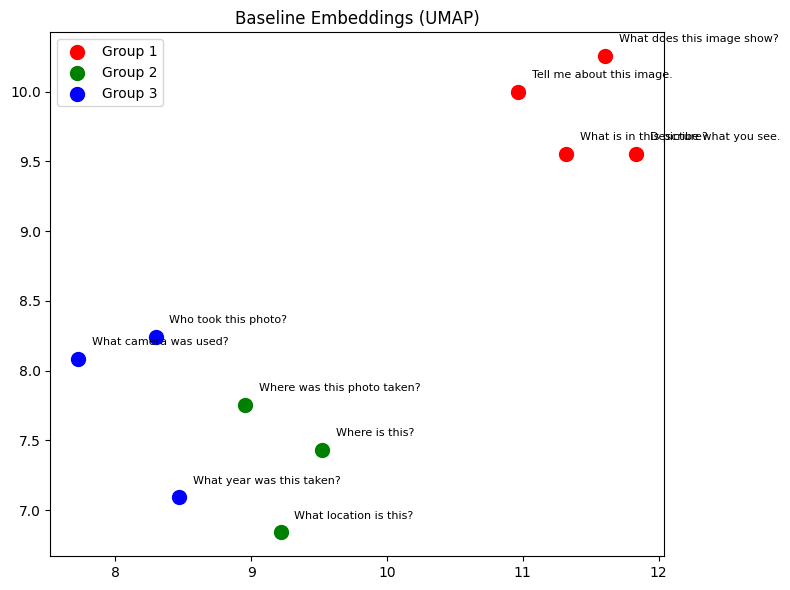

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


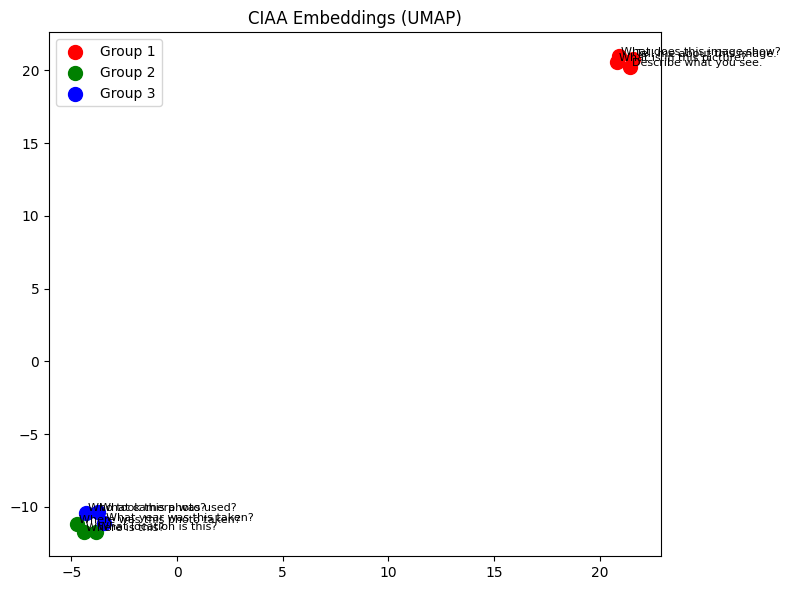

In [20]:
import umap

def plot_umap(embeddings, instructions, group_labels, title):
    reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, random_state=42)
    z_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    groups = np.unique(group_labels)
    colors = ["red", "green", "blue"]
    
    for i, g in enumerate(groups):
        idx = np.where(group_labels == g)
        plt.scatter(z_2d[idx,0], z_2d[idx,1], label=f"Group {g+1}", color=colors[i], s=100)
        for j in idx[0]:
            plt.text(z_2d[j,0]+0.1, z_2d[j,1]+0.1, instructions[j], fontsize=8)
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
# Make sure you have group labels for test instructions
group_labels_test = np.array([0,0,0,0, 1,1,1, 2,2,2])  # match your test_instructions

# Plot baseline embeddings
plot_umap(base_embs, test_instructions, group_labels_test, "Baseline Embeddings (UMAP)")

# Plot CIAA embeddings
plot_umap(ciaa_embs, test_instructions, group_labels_test, "CIAA Embeddings (UMAP)")


In [ ]:
import matplotlib.pyplot as plt

# Manually input the losses you printed
losses = [
    0.955336, 1.229960, 0.689033, 0.863716, 0.874540,
    0.822149, 1.329537, 0.836655, 0.701207, 0.642103
]

epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue', label='SupCon Loss')
plt.title("CIAA Projector Training Loss (SupCon)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
